In [1]:
using Pkg, Revise
Pkg.activate(".")

  Activating environment at `~/Desktop/SelectivelyAdaptiveLasso/Project.toml`


In [2]:
using CSV, DataFrames, VegaLite
import Statistics: mean

In [3]:
# import Distributions as Dist
# import LinearAlgebra: diagm

# n, p = 3000, 10

# X_dist = Dist.reshape(
#     Dist.MvNormal(zeros(p), 0.1ones(p,p) + 0.9diagm(ones(p))), 
#     (1,p)
# )
# ϵ_dist = Dist.Normal(0,1)

# X = vcat(rand(X_dist, n)...)
# ϵ = rand(ϵ_dist, n)

# Y = 5X[:,1] + X[:,2].^2 - 3X[:,3].*X[:,4] + ϵ
# Y = Y .- mean(Y)

# n_val = Int(round(n/2))
# X_val, Y_val = X[1:n_val,:], Y[1:n_val]
# X, Y = X[(n_val+1):end,:], Y[(n_val+1):end];

In [4]:
data_path = "/Users/aschuler/Desktop/uci-data/csv/"
datasets = ["concrete", "energy", "kin8nm", "naval", "power", "protein", "wine", "yacht"]

function get_data(dataset, path=data_path)
    df = CSV.read(
        open(data_path * dataset * ".csv"), 
        DataFrame, copycols=true
    )
    Y = float(df[:,end])
    X = Matrix(df[:,1:end-1])
    
    return X, Y
end

get_data (generic function with 2 methods)

In [5]:
for dataset in datasets
    X,Y = get_data(dataset)
    print(dataset, size(X), size(Y))
    print("\n")
end

concrete(1030, 8)(1030,)
energy(768, 9)(768,)
kin8nm(8192, 8)(8192,)
naval(11934, 17)(11934,)
power(9568, 4)(9568,)
protein(45730, 9)(45730,)
wine(1599, 11)(1599,)
yacht(308, 6)(308,)


In [6]:
using EllipsisNotation
import Random: shuffle

function train_test_split(arrays...; test_frac=0.1)
    n = size(arrays[1])[1]
    n_test = Int(round(n*test_frac))

    idx = shuffle(1:n)
    idx_test = idx[1:n_test]
    idx_train = idx[(n_test+1):end]
    
    return ((A[idx_train,..], A[idx_test,..]) for A in arrays)
end

train_test_split (generic function with 1 method)

In [16]:
Pkg.add("ProfileVega")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
    Updating `~/Desktop/SelectivelyAdaptiveLasso/Project.toml`
  [4391764f] + ProfileVega v1.1.1
    Updating `~/Desktop/SelectivelyAdaptiveLasso/Manifest.toml`
  [1520ce14] + AbstractTrees v0.3.4
  [5ae59095] + Colors v0.12.8
  [08572546] + FlameGraphs v0.2.8
  [9b13fd28] + IndirectArrays v1.0.0
  [1d6d02ad] + LeftChildRightSiblingTrees v0.1.3
  [4391764f] + ProfileVega v1.1.1
Precompiling project...
  ✓ SelectivelyAdaptiveLasso
  1 dependency successfully precompiled in 3 seconds (122 already precompiled)
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [9]:
using ProfileVega

(80.12202972163222, 97.87857847503362)
(39.021856943294466, 52.102712309912235)
(23.709826737104574, 30.637030262899266)
(20.00359195382457, 28.152044076902826)
(15.850577362095386, 25.152046894671763)
(13.243021422585104, 22.968182445495533)
(11.809060893693331, 22.115419086223724)
(10.611948013001326, 21.346597638669643)
(9.881930730179242, 21.066736531854247)
(9.265828990994716, 20.17800109269562)
(8.684983188995838, 19.505833921763994)
(8.088417130861563, 19.104730519015817)
(7.654825986297723, 19.314300605741092)
(7.267926718393047, 19.13064974145444)
(6.882052970151088, 19.03186662218893)
(6.584869994137795, 19.160913281433483)
(6.329420901862838, 19.27906345472001)
(6.105899349599012, 19.199661602601484)


ERROR: Exception handler triggered on unmanaged thread.


(5.920902347414716, 18.838384689164062)
(5.751241615729188, 18.496627952416777)
(5.6034146062041055, 18.47939466924254)
(5.470429613533873, 18.28980221595051)
(5.312364403699754, 18.2107847077539)
(5.157316687447836, 18.09694724451933)
(4.995507667288816, 18.027444588980423)
(4.860464759619383, 18.222221397570785)
(4.764612331566379, 18.28926896792081)
(4.6892007701668845, 18.300177528312787)
(4.613512456474418, 18.48360764640098)
(

ERROR: Exception handler triggered on unmanaged thread.


4.551724779495058, 18.617562163901532)
(4.4701546985906315, 18.659419382831725)
(4.380310947430442, 18.860531562369193)
(4.284028517600534, 18.990241659247772)
(4.219826400089822, 19.0611850004675)
(4.13829390123225, 19.16906541546574)
(4.06051765845193, 18.925819422484068)
(3.997985464948271, 18.548174443727927)
(3.958274392406143, 18.18931240498334)
(3.921442344550261, 17.946548174692627)
(3.884081027351348, 17.770061917059536)


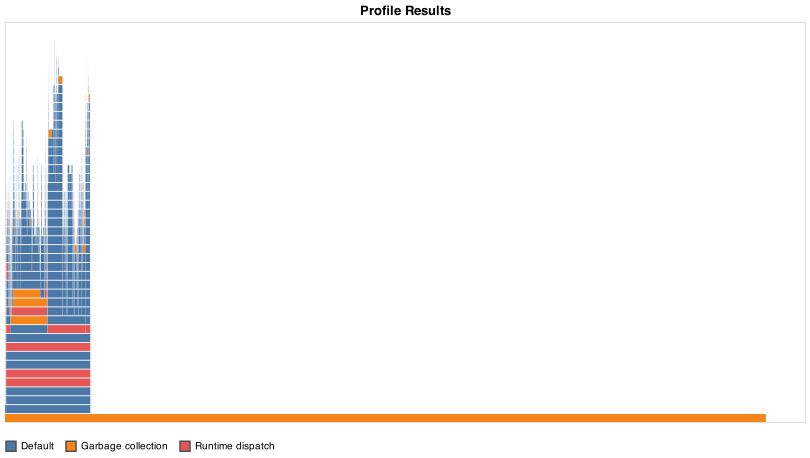

In [11]:
@profview SAL.fit(
    sal_spec, 
    X_tr, Y_tr, 
    X_val=X_val, Y_val=Y_val,
    verbose=true, print_iter=50,
)

In [12]:
ceil(4.4)

5.0

In [40]:
X,Y = get_data("concrete")
(X_tr_val, X_te), (Y_tr_val, Y_te) = train_test_split(X, Y, test_frac=0.1)
(X_tr, X_val), (Y_tr, Y_val) = train_test_split(X_tr_val, Y_tr_val, test_frac=0.2);

In [64]:
import SelectivelyAdaptiveLasso as SAL
# for testing
sal_spec = SAL.SALSpec(
    max_iter=Int(2000),
    λ = 0.0000001, 
    bases_per_iter=1,
    subsample_pct = 0.5,
    feat_pct = 0.7,
    tol = 1e-2,
)
@time sal_fit, (mse_tr, mse_val) = SAL.fit(
    sal_spec, 
    X_tr, Y_tr, 
    X_val=X_val, Y_val=Y_val,
    verbose=true, print_iter=100,
);

(66.10998154084038, 84.97651369151667)
(46.41626449466776, 52.366395224078516)
(29.646157269837737, 38.861231750221826)
(20.097541221464496, 36.00709926865953)
(13.537397954415518, 29.384139715362284)
(10.298991032954968, 25.6875422538318)
(8.780747663830509, 24.697956385896834)
(7.633046193294702, 24.352087875186374)
(6.747540329321687, 24.125520046856533)
(5.928396522206088, 24.15640020567344)
(5.225507602686972, 24.434313835998374)
(4.720972409542481, 24.89537953656898)
(4.271838137073182, 25.315212791055007)
(3.8955306179543574, 25.52852146760179)
(3.587863099676791, 25.896930568271554)
(3.3437819189833355, 26.316071621426588)
(3.149099086736514, 26.737936001755205)
(2.98232453273748, 26.99489953456164)
(2.8444994612577252, 27.3020466427882)
(2.7154883566750483, 27.649940684694144)
  7.492579 seconds (14.44 M allocations: 2.683 GiB, 5.55% gc time)


# Testing

In [7]:
import SelectivelyAdaptiveLasso as SAL
X,Y = get_data("naval")
H = SAL.Bases(X);

In [83]:
SAL.basis_search(H, Y, 0.001)
@benchmark SAL.basis_search(H, Y, 0.001)

BenchmarkTools.Trial: 118 samples with 1 evaluation.
 Range (min … max):  36.472 ms … 78.395 ms  ┊ GC (min … max): 0.00% … 50.69%
 Time  (median):     38.193 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   42.388 ms ± 11.455 ms  ┊ GC (mean ± σ):  9.86% ± 15.62%

  ▄▁█                                                          
  █████▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▁▃▁▂▃▂▂ ▂
  36.5 ms         Histogram: frequency by time        76.2 ms <

 Memory estimate: 40.92 MiB, allocs estimate: 911.

In [49]:
import StatsBase: sample
using BenchmarkTools
random_basis(H) = H.one_way[:,sample(1:H.n),sample(1:H.p)];

In [37]:
basis = random_basis(H)
@benchmark Y'*basis

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  15.567 μs … 185.576 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.104 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.886 μs ±   5.000 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ██▂▁                                                         ▂
  █████▆▅▄▁▃▁▁▄▃▁▁▁▁▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▃▁▃▅▇█▇▃▃▁▁▁▁▁▁▁▁▁▁▁▄ █
  15.6 μs       Histogram: log(frequency) by time      46.9 μs <

 Memory estimate: 32 bytes, allocs estimate: 2.

In [58]:
using SparseArrays
import Base: *, ∩

struct BoolSparseVector <: AbstractSparseVector{Bool,Int}
    length::Int
    nzind::Vector{Int}
end
BoolSparseVector(x::BitVector) = BoolSparseVector(length(x), findall(!iszero, x))

function *(v::Vector{Float64}, x::BoolSparseVector)
    return sum(v[i] for i in x.nzind)
end

In [59]:
sparse_basis = BoolSparseVector(basis)
Y * sparse_basis;
@benchmark Y * sparse_basis

BenchmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  3.608 μs …  44.945 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.611 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.768 μs ± 920.650 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  ▅▂                                                       ▁
  █▆███▆▆▄▄█▃▅▅▅▄▃▃▁▇▄▁▃▁▁▁▁▁▃▃▁▃▄▄▁▄▃▃▃▄▃▃▄▄▁▁▃▁▁▁▄▄▄▄▆▅▅▆▆▆ █
  3.61 μs      Histogram: log(frequency) by time      8.28 μs <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [60]:
u,v = random_basis(H), random_basis(H)
@benchmark u.*v

BenchmarkTools.Trial: 10000 samples with 202 evaluations.
 Range (min … max):  381.421 ns … 145.627 μs  ┊ GC (min … max):  0.00% … 99.40%
 Time  (median):     520.099 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   752.405 ns ±   5.269 μs  ┊ GC (mean ± σ):  27.90% ±  3.97%

  ▅▄▃▅▄▁  ▁█▅▅▇▇▄▃ ▁▁  ▁▁▁▁                                     ▂
  ██████▇▇███████████████████▇▇█▇▆▇█▇▇█▇▇▇▅▄▆▅▆▆▅▆▄▅▆▄▆▆▆▄▆▆▄▄▄ █
  381 ns        Histogram: log(frequency) by time       1.18 μs <

 Memory estimate: 1.69 KiB, allocs estimate: 4.

In [61]:
sparse_u, sparse_v = BoolSparseVector(u), BoolSparseVector(v)
@benchmark sparse_u ∩ sparse_v

BenchmarkTools.Trial: 5821 samples with 1 evaluation.
 Range (min … max):  657.265 μs …  21.104 ms  ┊ GC (min … max): 0.00% … 95.75%
 Time  (median):     811.727 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   855.094 μs ± 758.102 μs  ┊ GC (mean ± σ):  3.64% ±  3.95%

                  ▃▇█▅▃▁                                         
  ▂▂▂▂▂▂▁▂▂▂▂▄▆█████████▇▅▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  657 μs           Histogram: frequency by time         1.17 ms <

 Memory estimate: 367.80 KiB, allocs estimate: 21.

# SAL

In [ ]:
import SelectivelyAdaptiveLasso as SAL
result_path = "/Users/aschuler/Desktop/SAL-results/"

λs = ℯ .^range(-14, -5, length=10)

# loop over datasets
# change λ to denser range?

dataset_name = "protein"
X,Y = get_data(dataset_name)
test_rmses = []

Threads.@threads for run in 1:8
    (X_tr_val, X_te), (Y_tr_val, Y_te) = train_test_split(X, Y, test_frac=0.1)
    (X_tr, X_val), (Y_tr, Y_val) = train_test_split(X_tr_val, Y_tr_val, test_frac=0.2);
    metrics = []
    
    for λ in λs
        sal_spec = SAL.SALSpec(
            max_iter=200,
            λ = λ, 
            bases_per_iter=20,
            subsample_n = 300, 
            feat_pct = 0.33,
            tol = 1e-2,
        )
        stats = @timed sal_fit, (mse_tr, mse_val) = SAL.fit(
            sal_spec, 
            X_tr, Y_tr, 
            X_val=X_val, Y_val=Y_val,
            # verbose=true, print_iter=100,
        )
        mse, iter = findmin(mse_val)
        run_metrics = Dict(
            :mse => mse,
            :best_iter => iter,
            :time => stats.time,
            :spec => sal_spec,
        )
        # Core.println(run_metrics)
        push!(metrics, run_metrics)
    end

    min_mse, run_id = findmin([run[:mse] for run in metrics])
    params = metrics[run_id]
    new_spec = deepcopy(params[:spec])
    new_spec.max_iter = params[:best_iter]

    @time sal_fit, (mse_tr_val, mse_te) = SAL.fit(
        new_spec, 
        X_tr_val, Y_tr_val, 
        X_val=X_te, Y_val=Y_te,
        # verbose=true, print_iter=100,
    )
    test_rmse = sqrt(mse_te[end])
    push!(test_rmses, test_rmse)
end
result_df = DataFrame(:dataset=>dataset_name, :rmse=>test_rmses)
CSV.write(result_path*dataset_name*".csv", result_df)

# Plot

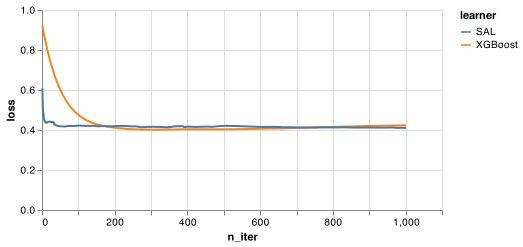

In [ ]:
df = vcat(df_xgb, df_sal);
df |>
@vlplot(
    :line,
    x=:n_iter,
    y=:loss,
    color=:learner,
    width=400,
    height=200
)